<a href="https://colab.research.google.com/github/nathanielborland/2024Fall-MOCS/blob/main/Assignment2CellularAutomata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Assignment #2: CA mini-project code**
Carina Manitius, Trevor Webster, Derek Devine, Nate Borland

# City Growth

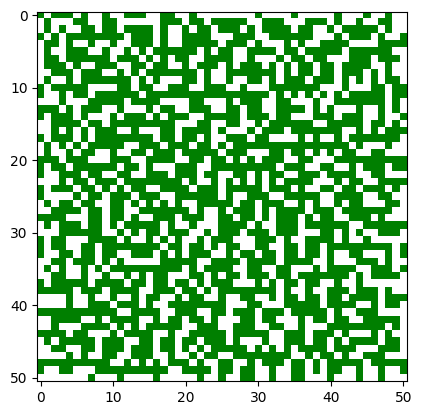

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display
import time

# length of one side of the world grid. world will be a (world_size x world_size) 2D array.
S = 51 # @param {type:"slider", min:0, max:111, step:1}

# probability (p_n) for green space with n urban neighbors to turn into urban space on each update
P_0 = 0 # @param {type:"slider", min:0, max:1, step:0.001}
P_1 = 0.1 # @param {type:"slider", min:0, max:1, step:0.001}
P_2 = 0.1 # @param {type:"slider", min:0, max:1, step:0.001}
P_3 = 0.1 # @param {type:"slider", min:0, max:1, step:0.001}
P_4 = 0.1 # @param {type:"slider", min:0, max:1, step:0.001}
P_5 = 0.1 # @param {type:"slider", min:0, max:1, step:0.001}
P_6 = 0.1 # @param {type:"slider", min:0, max:1, step:0.001}
P_7 = 0 # @param {type:"slider", min:0, max:1, step:0.001}
P_8 = 0 # @param {type:"slider", min:0, max:1, step:0.001}
P_9 = 0 # @param {type:"slider", min:0, max:1, step:0.001}
P_10 = 0 # @param {type:"slider", min:0, max:1, step:0.001}
P_11 = 0 # @param {type:"slider", min:0, max:1, step:0.001}
P_12 = 0 # @param {type:"slider", min:0, max:1, step:0.001}
P_13 = 0 # @param {type:"slider", min:0, max:1, step:0.001}
P_14 = 0 # @param {type:"slider", min:0, max:1, step:0.001}

# list of default urbanization chances
probs = [P_0, P_1, P_2, P_3, P_4, P_5, P_6, P_7,
         P_8, P_9, P_10, P_11, P_12, P_13, P_14]

# radius of the extended moore neighborhood considered for each cell update
# compute used increases drastically as this increases
R = 2 # @param {type:"slider", min:1, max:3, step:1}

# saturation threshold, number of updates which must pass without any changes for the city to be considered saturated
T = 5 # @param {type:"slider", min:1, max:10, step:1}

# toggles display of intermediate steps, disabling will skip to the end state and is much faster
animate_growth = True # @param {type:"boolean"}

# forced sleep on every update, for slowing down animations for very fast rule sets
forced_sleep = 0 # @param {type:"slider", min:0, max:1, step:0.1}

# displays the current state of world cells
def display_world(world):
    plt.imshow(np.flipud(world), cmap=plt.get_cmap(cm.ocean))
    display.display(plt.gcf())
    display.clear_output(wait=True)

# gets the square neighborhood within radius of the cell at i,j in world
# treats cells with i or j less than 0 or greater than world_size - 1 as 0
def get_neighborhood(world, i, j):
    # WIP better rules that treat indices outside the world as 0, not working
    neighborhood = np.zeros(((R*2)+1,(R*2)+1))
    for k in range(i-R, i+R+1):
        for l in range(j-R, j+R+1):
            if not (k < 0 or l < 0 or k > S-1 or l > S-1):
                neighborhood[k-(i-R)][l-(j-R)] = world[k][l]
    return neighborhood

## Explicit zoning rules for each neighbor count
def get_next_state(neighborhood):
    chance = probs[min(len(probs)-1, np.count_nonzero(neighborhood))]
    if chance > 0 and np.random.rand() < chance:
        return 1
    else:
        return 0

# checks each cell in world and applies the results of get_next_state
def update_world(world):
    next_world = world.copy()
    for i in range(S):
        for j in range(S):
            # urban space cannot turn into green space in this model so we can skip it
            if world[i][j] == 1:
                continue
            next_world[i][j] = get_next_state(get_neighborhood(world, i, j))
    return next_world

# set up 'world', a (size x size) 2D array of all zeros (green space)
world = np.zeros((S,S))
# set up a single 1 (urban space) in the center
world[S//2,S//2] = 1

# set up completion conditions
finished = False
force_sleep = forced_sleep > 0
num_unchanged_updates = 0

# main update loop
while not finished:
    # display current world state
    if animate_growth:
        display_world(world)
        if force_sleep:
            time.sleep(forced_sleep)
    # compute next world state
    next_world = update_world(world)
    # check if world changed in the last update
    if np.array_equal(world, next_world):
        num_unchanged_updates += 1
    else:
        num_unchanged_updates = 0
    # check if world is sufficiently settled
    if num_unchanged_updates > T:
        finished = True
    # update world state
    world = next_world

# display final state of the world
display_world(world)

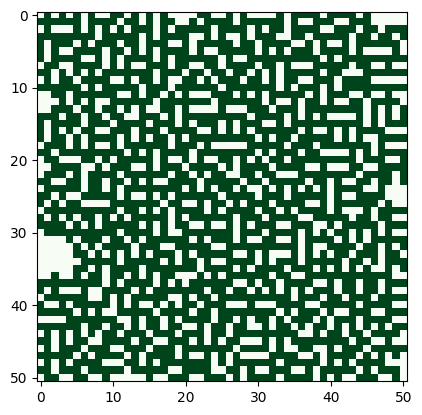

In [27]:
from scipy.ndimage import label

def biggest_greenspace(world):
    # Using scipy's label function to identify contiguous clusters of 0's (greenspace)
    labeled_world, num_features = label(world == 0)

    if num_features == 0:
        return  # If no clusters, exit function

    # Find the size of each cluster
    sizes = np.bincount(labeled_world.ravel())

    # Find the label corresponding to the largest cluster
    largest_cluster_label = np.argmax(sizes[1:]) + 1

    # Create an array where only the largest cluster is marked
    largest_cluster = (labeled_world == largest_cluster_label).astype(int)

    # Plot the largest cluster of 0's (greenspace)
    plt.figure()
    plt.imshow(np.flipud(largest_cluster), cmap=plt.get_cmap('Greens'))
    plt.show()

largest_cluster_size = biggest_greenspace(world)



In [3]:
import numpy as np

def divide_into_boxes(arr, r):
    # Get the size of the original array
    n = arr.shape[0]
    arr = np.array(arr)
    if n % r != 0:
        raise ValueError("The size of the array must be divisible by the block size.")

    # Reshape and swap axes to divide the array into r x r boxes
    boxes = arr.reshape(n // r, r, n // r, r).swapaxes(1, 2)
    return boxes

# Counts number of boxes of size r to cover the structure 
def box_count(arr, r):
    n = 0
    boxes = divide_into_boxes(arr, r)
    for i in range(boxes.shape[0]):
        for j in range(boxes.shape[1]):
            # print(f"Box ({i}, {j}):")
            # print(boxes[i, j])
            # print()
            if np.any(boxes[i,j]==1):
                n += 1

    return n

# Counts boxes to cover structure for all r divisors
def box_count_all_r(world):
    res = []
    arr = world
    n = world.shape[0]
    divisors = [r for r in range(1, n+1) if n % r == 0]
    for r in divisors:
        n = box_count(arr,r)
        res.append((r, r/n, n ))
    return res

# Example usage


res = (box_count_all_r(world))
print(res)
# boxes = divide_into_boxes(arr, r)

# # Print the resulting blocks
# print(boxes)

# print(f"Shape of blocks: {boxes.shape}")
# print(box_count(arr, r))


[(1, 0.0009505703422053232, 1052), (3, 0.010416666666666666, 288), (17, 1.8888888888888888, 9), (51, 51.0, 1)]


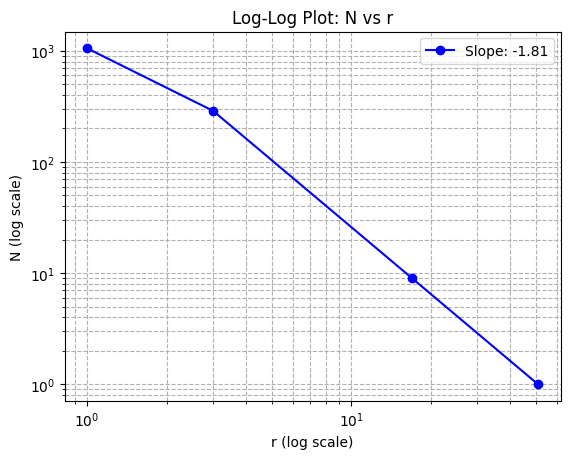

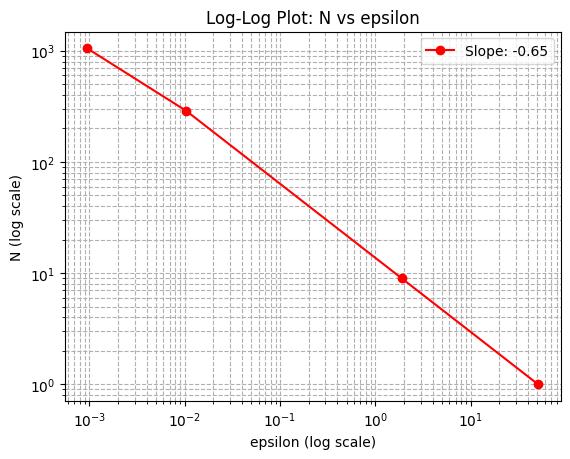

(np.float64(-1.8069582916644826), np.float64(-0.6450542301951218))

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Data: (r, epsilon, N)

# Extracting the columns into individual arrays
r = np.array([x[0] for x in res])
epsilon = np.array([x[1] for x in res])
N = np.array([x[2] for x in res])

def plot_with_slope(x, y, xlabel, ylabel, title, color='b'):
    # Perform log-log regression to calculate slope
    slope, intercept = np.polyfit(np.log10(x), np.log10(y), 1)
    
    # Plot the data
    fig, ax = plt.subplots()
    ax.loglog(x, y, marker='o', linestyle='-', color=color, label=f'Slope: {slope:.2f}')
    ax.set_xlabel(f'{xlabel} (log scale)')
    ax.set_ylabel(f'{ylabel} (log scale)')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both", ls="--")
    return fig, slope

# Create both plots with slopes
fig1, slope1 = plot_with_slope(r, N, 'r', 'N', 'Log-Log Plot: N vs r', 'b')
fig2, slope2 = plot_with_slope(epsilon, N, 'epsilon', 'N', 'Log-Log Plot: N vs epsilon', 'r')

# Display plots
plt.show()

# Print slopes for reference
slope1, slope2

# Greenspace metrics

In [28]:
from scipy.ndimage import label

# 1. Metric: share_greenspace (% of greenspace cells)
def share_greenspace(world):
    total_cells = S * S
    greenspace_cells = np.sum(world == 0)
    return greenspace_cells / total_cells

# 2. Metric: biggest_greenspace (largest cluster of contiguous greenspace cells)
def biggest_greenspace(world):
    # Using scipy's label function to identify contiguous clusters of 0's (greenspace)
    labeled_world, num_features = label(world == 0)
    if num_features == 0:
        return 0
    # Find the size of each cluster and return the largest
    sizes = np.bincount(labeled_world.ravel())
    return sizes[1:].max()  # exclude the background (index 0)

# 3. Metric: access_greenspace (urban cells bordering greenspace)
def access_greenspace(world):
    access_count = 0
    total_urban_cells = np.sum(world == 1)  # count the number of urban cells
    for i in range(S):
        for j in range(S):
            if world[i][j] == 1:  # only look at urban cells
                # Get von Neumann neighborhood (up, down, left, right)
                neighbors = [
                    (i-1, j),  # up
                    (i+1, j),  # down
                    (i, j-1),  # left
                    (i, j+1)   # right
                ]
                for ni, nj in neighbors:
                    if 0 <= ni < S and 0 <= nj < S and world[ni][nj] == 0:
                        access_count += 1
                        break  # no need to check further if greenspace is found

    if total_urban_cells == 0:
        return 0  # avoid division by zero if there are no urban cells

    return access_count / total_urban_cells  # return percentage

# 4. Metric: average_greenspace (average size of greenspace clusters)
def average_greenspace(world):
    labeled_world, num_features = label(world == 0)
    if num_features == 0:
        return 0
    # Find the size of each cluster
    sizes = np.bincount(labeled_world.ravel())
    return sizes[1:].mean()  # exclude the background (index 0)

# Compute and display the metrics
final_share_greenspace = share_greenspace(world)
final_biggest_greenspace = biggest_greenspace(world)
final_access_greenspace = access_greenspace(world)
final_average_greenspace = average_greenspace(world)

print(f"Share of Greenspace: {final_share_greenspace:.2%}")
print(f"Largest Greenspace Cluster: {final_biggest_greenspace} cells")
print(f"Percentage of Urban Cells with Greenspace Access: {final_access_greenspace:.2%}")
print(f"Average Greenspace Cluster Size: {final_average_greenspace:.2f} cells")

Share of Greenspace: 66.09%
Largest Greenspace Cluster: 1691 cells
Percentage of Urban Cells with Greenspace Access: 100.00%
Average Greenspace Cluster Size: 191.00 cells


# Loop runs and collect metrics

In [47]:
# Number of simulation runs
num_runs = 100  # Change this to the desired number of runs

# Initialize lists to store metrics for each run
share_greenspace_list = []
biggest_greenspace_list = []
access_greenspace_list = []
average_greenspace_list = []

# Run the simulation multiple times
for run in range(num_runs):
    # Reset world for each run
    world = np.zeros((S, S))
    world[S // 2, S // 2] = 1  # starting condition with one urban cell in the center

    finished = False
    reached_edge = False

    # Main update loop for the simulation
    while not finished:
        (next_world, touched_edge) = update_world(world)

        if touched_edge:
            reached_edge = True
        if reached_edge and np.array_equal(world, next_world):
            finished = True
        world = next_world

    # Compute metrics for the final state of the world
    final_share_greenspace = share_greenspace(world)
    final_biggest_greenspace = biggest_greenspace(world)
    final_access_greenspace = access_greenspace(world)  
    final_average_greenspace = average_greenspace(world)

    # Append metrics to their respective lists
    share_greenspace_list.append(final_share_greenspace)
    biggest_greenspace_list.append(final_biggest_greenspace)
    access_greenspace_list.append(final_access_greenspace)
    average_greenspace_list.append(final_average_greenspace)

# Calculate averages of the metrics
average_share_greenspace = np.mean(share_greenspace_list)
average_biggest_greenspace = np.mean(biggest_greenspace_list)
average_access_greenspace = np.mean(access_greenspace_list)
average_average_greenspace = np.mean(average_greenspace_list)

# Print the average metrics across all runs
print(f"Average Share of Greenspace: {average_share_greenspace:.2%}")
print(f"Average Largest Greenspace Cluster: {average_biggest_greenspace:.2f} cells")
print(f"Average Percentage of Urban Cells with Greenspace Access: {average_access_greenspace:.2%}")
print(f"Average Greenspace Cluster Size: {average_average_greenspace:.2f} cells")

Average Share of Greenspace: 42.73%
Average Largest Greenspace Cluster: 47.83 cells
Average Percentage of Urban Cells with Greenspace Access: 88.81%
Average Greenspace Cluster Size: 4.57 cells


In [ ]:
import numpy as np
import random

# Random walker
def run_random_walker(world, position, history, steps):
    N1 = world.shape[0]
    N2 = world.shape[1]
    (i,j) = position
    for k in range(steps): #for every step
        for i in np.arange(0, N1, 1):
          for j in np.arange(0, N2, 1):
            world[position] = 0.67
            (i,j) = position
            die = random.uniform(0, 1)
            if die<0.5: #bottom step
              world[position] = 1
            history.append(position)

    return (world,position,history)

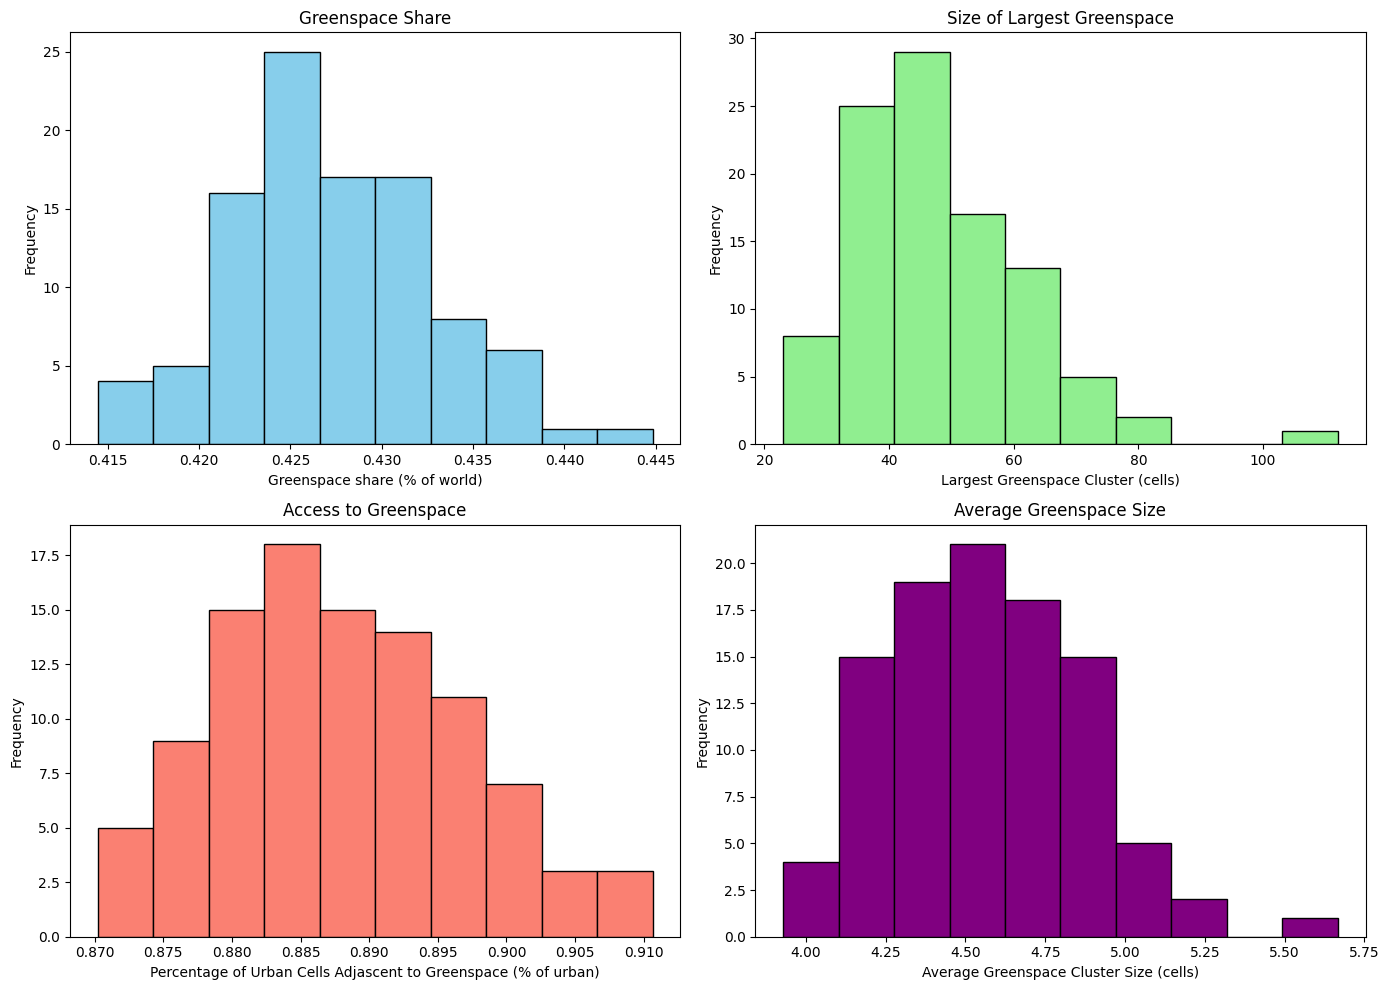

In [48]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
import random

# Share of Greenspace
plt.subplot(2, 2, 1)
plt.hist(share_greenspace_list, bins=10, color='skyblue', edgecolor='black')
plt.title('Greenspace Share')
plt.xlabel('Greenspace share (% of world)')
plt.ylabel('Frequency')

# Parameters
n, S, K, steps = 32, 2, 3, 32 #size, states, neighbors, steps
rule = 30 #rule number
tape = np.zeros(n) #initial conditions of zero
tape[n//2] = 1 #initial conditions
#tape = np.random.randint(2, size=N) #random initial conditions

# Run the CA
#tapes = run_1d_CA(steps,tape)
#tapes = run_rule_30(steps,tape)
tapes = run_cellauto(S, K, decode_rule(rule, S, K), steps, tape) #run model

# Average Greenspace Cluster Size
plt.subplot(2, 2, 4)
plt.hist(average_greenspace_list, bins=10, color='purple', edgecolor='black')
plt.title('Average Greenspace Size')
plt.xlabel('Average Greenspace Cluster Size (cells)')
plt.ylabel('Frequency')

# Add rule label
#ax.text(2, steps+0.5, f'Cellular automaton', color='Orange', fontsize=20)
ax.text(2, steps+0.5, f'Rule {rule}', color='Orange', fontsize=20)
plt.show()